In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import (
    RobertaTokenizer, 
    RobertaForSequenceClassification, 
    RobertaConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    AutoConfig,
    TrainingArguments, 
    Trainer, 
    EarlyStoppingCallback
)
# from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.metrics import mean_squared_error
import evaluate
import os
from dataclasses import dataclass
from typing import Dict, List, Optional, Union

import pandas as pd
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from transformers import TrainerCallback, DataCollatorWithPadding
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

/rhome/sawale/FunnyProject/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define constants
MAX_LEN = 128
TARGET_COLUMNS = ['humor', 'offensiveness', 'sentiment']
# TARGET_COLUMNS = [ 'offensiveness', 'sentiment',  'humor']
NUM_TARGETS = len(TARGET_COLUMNS)
MODEL_CHECKPOINT = "FacebookAI/roberta-base" 

In [4]:
class CustomTrainer(Trainer):
    def __init__(self, *args, focal_loss_gamma=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.focal_loss_gamma = focal_loss_gamma

    def focal_binary_cross_entropy(self, logits, targets):
        # Apply sigmoid to logits to get probabilities
        p = torch.sigmoid(logits)
        # Calculate focal loss
        p_t = torch.where(targets == 1, p, 1 - p)
        log_p_t = torch.log(torch.clamp(p_t, min=1e-4, max=1 - 1e-4))  # Cross Entropy
        loss = - (1 - p_t) ** self.focal_loss_gamma * log_p_t
        return loss.mean()

    def compute_loss(self, model, inputs, num_items_in_batch=None, return_outputs=False):
        labels = inputs.get("labels")
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Compute focal loss
        loss = self.focal_binary_cross_entropy(logits.view(-1), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


In [ ]:
# Custom callback to record loss history
class LossHistory(TrainerCallback):
    def __init__(self):
        self.train_losses = []  # to store (global_step, training loss)
        self.eval_losses = []   # to store (global_step, evaluation loss)
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        # Log training loss if available
        if logs is not None and "loss" in logs:
            self.train_losses.append((state.global_step, logs["loss"]))
    
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        # Log evaluation loss if available
        if metrics is not None and "eval_loss" in metrics:
            self.eval_losses.append((state.global_step, metrics["eval_loss"]))

def plot_loss_history(loss_history, save_path="loss_plot.png"):
    """
    Plots the training and evaluation loss curves stored in the loss_history callback.
    """
    if loss_history.train_losses:
        train_steps, train_loss_values = zip(*loss_history.train_losses)
    else:
        train_steps, train_loss_values = [], []
    
    if loss_history.eval_losses:
        eval_steps, eval_loss_values = zip(*loss_history.eval_losses)
    else:
        eval_steps, eval_loss_values = [], []
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_steps, train_loss_values, label="Training Loss", marker='o')
    plt.plot(eval_steps, eval_loss_values, label="Evaluation Loss", marker='o')
    plt.xlabel("Global Step")
    plt.ylabel("Loss")
    plt.title("Training and Evaluation Loss Over Time")
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    print(f"Loss plot saved as '{save_path}'.")

# Function to load data from a parquet file and process targets
def load_data(file_path, nrows=None):
    # Load dataset from a Parquet file
    df = pd.read_parquet(file_path)
    if nrows:
        df = df.head(nrows)
    
    # Cast the target columns to int for classification purposes.
    df[TARGET_COLUMNS] = df[TARGET_COLUMNS].astype(int)
    
    # Drop rows where any value in the target columns isn't 0 or 1.
    # This creates a boolean mask that checks for binary values.
    df = df[df[TARGET_COLUMNS].isin([0, 1]).all(axis=1)]

    df[TARGET_COLUMNS] = df[TARGET_COLUMNS].astype(float)
    
    # Ensure that the 'joke' column is of type string.
    df['joke'] = df['joke'].astype(str)

    # drop duplicates
    df = df.drop_duplicates(subset=['joke'])
    # drop empty jokes
    df = df[df['joke'].str.strip() != '']
    # shuffle the dataframe
    df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

    
    return df


# Custom dataset class for classification
class JokeDataset(Dataset):
    def __init__(self, jokes, targets, tokenizer, max_len):
        self.jokes = jokes
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.jokes)
    
    def __getitem__(self, idx):
        joke = str(self.jokes[idx])
        # Convert target values to float for BCEWithLogitsLoss (they are binary: 0 or 1)
        targets = np.array(self.targets[idx]).astype(np.float32)
        
        encoding = self.tokenizer.encode_plus(
            joke,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(targets, dtype=torch.float)
        }
    

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

# Define the compute_metrics function for multi-label classification
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Apply sigmoid to get probabilities
    sigmoid_preds = 1 / (1 + np.exp(-predictions))
    # Threshold probabilities at 0.5 for binary predictions
    binary_preds = (sigmoid_preds > 0.5).astype(int)
    
    # Compute precision, recall, and f1 scores for each target
    precision_list = []
    recall_list = []
    f1_list = []
    
    for i in range(NUM_TARGETS):
        precision = precision_score(labels[:, i], binary_preds[:, i], zero_division=0)
        recall = recall_score(labels[:, i], binary_preds[:, i], zero_division=0)
        f1 = f1_score(labels[:, i], binary_preds[:, i], zero_division=0)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
    
    results = {
        "precision": np.mean(precision_list),
        "recall": np.mean(recall_list),
        "f1": np.mean(f1_list)
    }
    for i, target in enumerate(TARGET_COLUMNS):
        results[f"precision_{target}"] = precision_list[i]
        results[f"recall_{target}"] = recall_list[i]
        results[f"f1_{target}"] = f1_list[i]
    
    return results


def iterative_split_dataframe(df, target_columns, input_columns=None, train_size=0.8, val_size=0.1, test_size=0.1):
    """
    Splits a multi-label DataFrame into train, validation, and test sets using iterative stratification.

    Args:
        df (pd.DataFrame): Full dataframe with both input features and target labels.
        target_columns (list): List of column names that are the target labels.
        input_columns (list, optional): List of input feature columns. If None, inferred from df.
        train_size (float): Proportion of data for training.
        val_size (float): Proportion of data for validation.
        test_size (float): Proportion of data for testing.

    Returns:
        (train_df, val_df, test_df): Tuple of DataFrames.
    """
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Splits must sum to 1"

    if input_columns is None:
        input_columns = [col for col in df.columns if col not in target_columns]

    X = df[input_columns]
    y = df[target_columns]

    # First split: train and temp
    temp_ratio = 1 - train_size
    X_train, y_train, X_temp, y_temp = iterative_train_test_split(X.values, y.values, test_size=temp_ratio)

    # Second split: val and test from temp
    val_ratio = val_size / (val_size + test_size)
    X_val, y_val, X_test, y_test = iterative_train_test_split(X_temp, y_temp, test_size=1 - val_ratio)

    # Reconstruct DataFrames
    train_df = pd.concat([pd.DataFrame(X_train, columns=input_columns),
                          pd.DataFrame(y_train, columns=target_columns)], axis=1)
    
    val_df = pd.concat([pd.DataFrame(X_val, columns=input_columns),
                        pd.DataFrame(y_val, columns=target_columns)], axis=1)

    test_df = pd.concat([pd.DataFrame(X_test, columns=input_columns),
                         pd.DataFrame(y_test, columns=target_columns)], axis=1)

    return train_df, val_df, test_df


def plot_probability_distributions(probabilities, labels, split_name, target_columns):
    """
    Plots the distribution of predicted probabilities for each target.
    
    Args:
        probabilities (np.ndarray): Array of shape (num_samples, num_targets) with probabilities.
        labels (np.ndarray): Actual labels (not used in plot but could be overlaid).
        split_name (str): Either "Train" or "Test" to label the plot.
        target_columns (list): List of target column names.
    """
    num_targets = len(target_columns)
    plt.figure(figsize=(5 * num_targets, 5))

    for i in range(num_targets):
        plt.subplot(1, num_targets, i + 1)
        sns.histplot(probabilities[:, i], bins=50, kde=True, color='skyblue')
        plt.title(f"{split_name} Set - {target_columns[i]}")
        plt.xlabel("Predicted Probability")
        plt.ylabel("Frequency")
        plt.xlim(0, 1)

    plt.tight_layout()
    plt.savefig(f"{split_name.lower()}_probability_distributions.png")
    plt.show()

    
def main(data_path, nrows):
    # Load data
    print(f"Loading data from {data_path}")
    df = load_data(data_path, nrows=nrows)

    # Split data into train, validation, and test sets (80%, 10%, 10%)
    train_df, val_df, test_df = iterative_split_dataframe(df, target_columns=TARGET_COLUMNS, input_columns=["joke"], train_size=0.8, val_size=0.1, test_size=0.1)
    
    print(f"Train set: {len(train_df)} samples")
    print(f"Validation set: {len(val_df)} samples")
    print(f"Test set: {len(test_df)} samples")
    
    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    input_to_encoding = lambda x: tokenizer(
        list(x.values.flatten()), return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=MAX_LEN,
        return_attention_mask=True
    )

    
    # Create datasets
    train_dataset = JokeDataset(
        jokes=train_df['joke'].values,
        targets=train_df[TARGET_COLUMNS].values,
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
    
    val_dataset = JokeDataset(
        jokes=val_df['joke'].values,
        targets=val_df[TARGET_COLUMNS].values,
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
    
    test_dataset = JokeDataset(
        jokes=test_df['joke'].values,
        targets=test_df[TARGET_COLUMNS].values,
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
    
    # Configure the model for multi-label classification
    config = AutoConfig.from_pretrained(MODEL_CHECKPOINT)
    config.num_labels = NUM_TARGETS
    config.problem_type = "multi_label_classification"
    
    # Add id to label and label to id mappings to the model config
    id2label = {i: label for i, label in enumerate(TARGET_COLUMNS)}
    label2id = {label: i for i, label in enumerate(TARGET_COLUMNS)}
    config.id2label = id2label
    config.label2id = label2id
    print("Mapping id to label:", config.id2label)
    print("Mapping label to id:", config.label2id)
    
    # Initialize model; using AutoModelForSequenceClassification sets up BCEWithLogitsLoss internally.
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_CHECKPOINT,
        config=config
    )
    
    # Optionally, freeze the base model layers if you want to fine-tune only the classification head
    for param in model.base_model.parameters():
        param.requires_grad = True

    # Instantiate loss history callback
    loss_history = LossHistory()
    
    # Set up training arguments (note that we now use "f1" as our metric for best model)
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=10,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        warmup_steps=300,
        weight_decay=0.1,
        logging_dir='./logs',
        logging_steps=150,
        eval_steps=150,
        save_steps=150,
        evaluation_strategy="steps",
        save_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        save_total_limit=2,
        learning_rate=5.0e-6
        # fp16=True,  # Uncomment if using mixed precision
    )
    
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3), loss_history],
        data_collator=data_collator,
        focal_loss_gamma=1.5,
    )
    

    # Train the model
    print("Starting training...")
    trainer.train()
    plot_loss_history(loss_history, save_path="loss_plot.png")
    
    # Evaluate on test set
    print("Evaluating on test set...")
    test_results = trainer.evaluate(test_dataset)
    print("Test results:", test_results)
    
    # Save model
    print("Saving model...")
    trainer.save_model("./joke_classification_model")
    
    # Generate classification report for Train set
    print("Generating classification report for the Train set...")
    train_predictions = trainer.predict(train_dataset)
    train_logits = train_predictions.predictions
    train_labels = train_predictions.label_ids
    # Apply sigmoid and threshold to get binary predictions
    train_sigmoid = 1 / (1 + np.exp(-train_logits))
    train_binary_preds = (train_sigmoid > 0.5).astype(int)
    
    train_report = classification_report(train_labels, train_binary_preds, target_names=TARGET_COLUMNS, zero_division=0)
    print("Train Classification Report:")
    print(train_report)
    
    # Generate classification report for Test set
    print("Generating classification report for the Test set...")
    test_predictions = trainer.predict(test_dataset)
    test_logits = test_predictions.predictions
    test_labels = test_predictions.label_ids
    test_sigmoid = 1 / (1 + np.exp(-test_logits))
    test_binary_preds = (test_sigmoid > 0.5).astype(int)
    
    test_report = classification_report(test_labels, test_binary_preds, target_names=TARGET_COLUMNS, zero_division=0)
    print("Test Classification Report:")
    print(test_report)
    
    # (Optional) Save predictions/actuals for further analysis
    print("Sample binary predictions (first 5):", test_binary_preds[:5])

    plot_probability_distributions(train_sigmoid, train_labels, "Train", TARGET_COLUMNS)
    plot_probability_distributions(test_sigmoid, test_labels, "Test", TARGET_COLUMNS)


    
    # Return results for further use if needed
    return {
        "model": model,
        "test_results": test_results,
        "train_report": train_report,
        "test_report": test_report,
        "raw_predictions": test_logits,
        "binary_predictions": test_binary_preds,
        "actual_values": test_labels
    }


def predict_joke_ratings(joke_text, model_path="./joke_classification_model"):
    """
    Use the trained classification model to predict ratings for a new joke.
    
    Args:
        joke_text (str): The text of the joke to rate.
        model_path (str): Path to the saved model.
    
    Returns:
        dict: Predicted ratings (0/1) for each metric, with labels from the model configuration.
    """
    tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
    # Load the model configuration and extract the id2label mapping
    config = AutoConfig.from_pretrained(model_path)
    id2label = config.id2label  # id2label should be a dict with integer keys mapping to target labels
    
    # Load the model using the updated configuration
    model = AutoModelForSequenceClassification.from_pretrained(model_path, config=config)
    model.eval()
    
    # Tokenize the joke text
    encoding = tokenizer.encode_plus(
        joke_text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    # Perform inference
    with torch.no_grad():
        outputs = model(
            input_ids=encoding['input_ids'],
            attention_mask=encoding['attention_mask']
        )
        logits = outputs.logits.cpu().numpy()[0]
    
    # Convert logits to probabilities and then to binary predictions
    sigmoid_probs = 1 / (1 + np.exp(-logits))
    binary_preds = (sigmoid_probs > 0.5).astype(int)
    
    # Use the id2label mapping from the model configuration to form the results
    results = {id2label[i]: int(pred) for i, pred in enumerate(binary_preds)}
    return results


Loading data from ../data/labeled_jokes_classification_mistral:latest.parquet
Train set: 44220 samples
Validation set: 5531 samples
Test set: 5527 samples


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mapping id to label: {0: 'humor', 1: 'offensiveness', 2: 'sentiment'}
Mapping label to id: {'humor': 0, 'offensiveness': 1, 'sentiment': 2}


/rhome/sawale/FunnyProject/.venv/lib/python3.11/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


/rhome/sawale/FunnyProject/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Precision Humor,Recall Humor,F1 Humor,Precision Offensiveness,Recall Offensiveness,F1 Offensiveness,Precision Sentiment,Recall Sentiment,F1 Sentiment
150,0.199500,0.167206,0.777563,0.735573,0.703631,0.730140,0.972178,0.833952,0.751708,0.234542,0.357530,0.850841,1.000000,0.919410
300,0.156600,0.146405,0.811174,0.786280,0.784711,0.790040,0.924409,0.851959,0.756944,0.464819,0.575958,0.886536,0.969613,0.926215
450,0.148700,0.141272,0.809228,0.806509,0.800403,0.802804,0.916798,0.856023,0.737673,0.531628,0.617926,0.887206,0.971101,0.927260
600,0.144000,0.139205,0.813030,0.815385,0.811711,0.816149,0.909974,0.860511,0.712479,0.600569,0.651755,0.910463,0.935614,0.922867
750,0.135600,0.139230,0.807405,0.829397,0.818184,0.836282,0.880840,0.857983,0.670175,0.678749,0.674435,0.915759,0.928602,0.922135
900,0.130200,0.134559,0.827435,0.815725,0.815741,0.824666,0.907349,0.864034,0.760952,0.567875,0.650387,0.896687,0.971951,0.932803
1050,0.128700,0.138161,0.815397,0.821257,0.818295,0.844987,0.862730,0.853766,0.680228,0.677328,0.678775,0.920975,0.923714,0.922342
1200,0.129400,0.132704,0.823342,0.826490,0.823255,0.834553,0.897638,0.864947,0.726678,0.631130,0.675542,0.908795,0.950701,0.929276
1350,0.129100,0.136110,0.823522,0.826466,0.822017,0.825468,0.913648,0.867323,0.736887,0.609097,0.666926,0.908211,0.956651,0.931802
1500,0.120700,0.137969,0.810085,0.830476,0.819796,0.857409,0.844357,0.850833,0.654746,0.715707,0.683871,0.918098,0.931364,0.924684


/rhome/sawale/FunnyProject/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/rhome/sawale/FunnyProject/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/rhome/sawale/FunnyProject/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/rhome/sawale/FunnyProject/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/rhome/sawal

Loss plot saved as 'loss_plot.png'.
Evaluating on test set...


/rhome/sawale/FunnyProject/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test results: {'eval_loss': 0.13467387855052948, 'eval_precision': 0.8145284583887795, 'eval_recall': 0.8139501412195574, 'eval_f1': 0.8119662176589939, 'eval_precision_humor': 0.8227360308285164, 'eval_recall_humor': 0.8968233132055657, 'eval_f1_humor': 0.8581836452706947, 'eval_precision_offensiveness': 0.7109044801352493, 'eval_recall_offensiveness': 0.5981507823613087, 'eval_f1_offensiveness': 0.6496716879103901, 'eval_precision_sentiment': 0.909944864202573, 'eval_recall_sentiment': 0.9468763280917977, 'eval_f1_sentiment': 0.9280433197958972, 'eval_runtime': 23.5432, 'eval_samples_per_second': 234.76, 'eval_steps_per_second': 0.934, 'epoch': 2.3878437047756873}
Saving model...
Generating classification report for the Train set...


/rhome/sawale/FunnyProject/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Train Classification Report:
               precision    recall  f1-score   support

        humor       0.86      0.92      0.89     30476
offensiveness       0.79      0.69      0.73     11250
    sentiment       0.92      0.95      0.94     37646

    micro avg       0.88      0.90      0.89     79372
    macro avg       0.85      0.86      0.85     79372
 weighted avg       0.88      0.90      0.89     79372
  samples avg       0.88      0.90      0.88     79372

Generating classification report for the Test set...


/rhome/sawale/FunnyProject/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test Classification Report:
               precision    recall  f1-score   support

        humor       0.82      0.90      0.86      3809
offensiveness       0.71      0.60      0.65      1406
    sentiment       0.91      0.95      0.93      4706

    micro avg       0.85      0.88      0.86      9921
    macro avg       0.81      0.81      0.81      9921
 weighted avg       0.85      0.88      0.86      9921
  samples avg       0.85      0.87      0.85      9921

Sample binary predictions (first 5): [[1 0 1]
 [1 0 1]
 [0 0 1]
 [1 0 1]
 [1 0 1]]


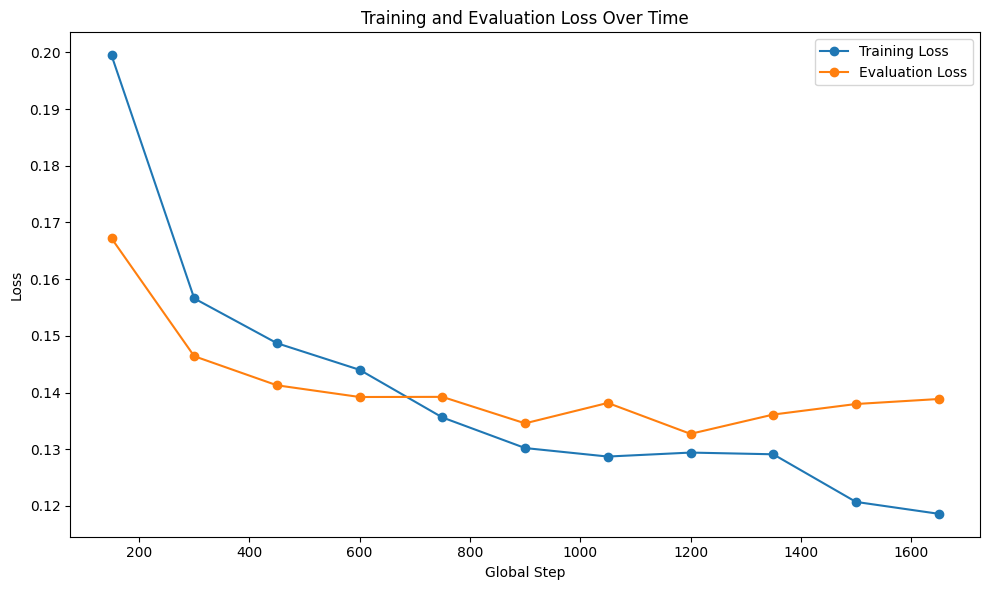

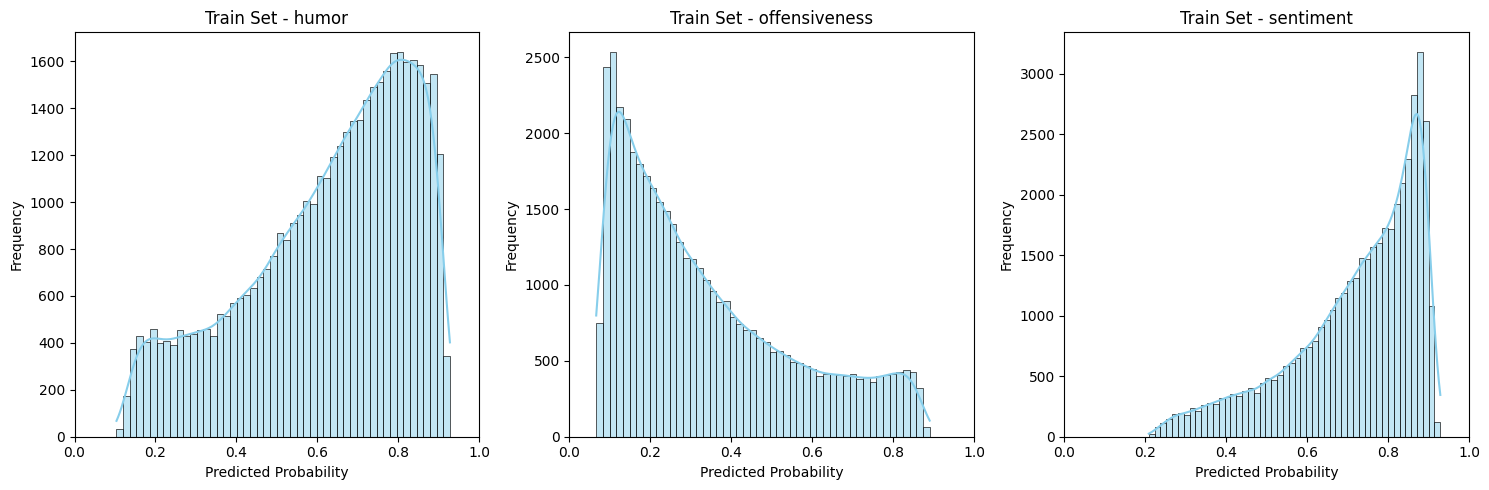

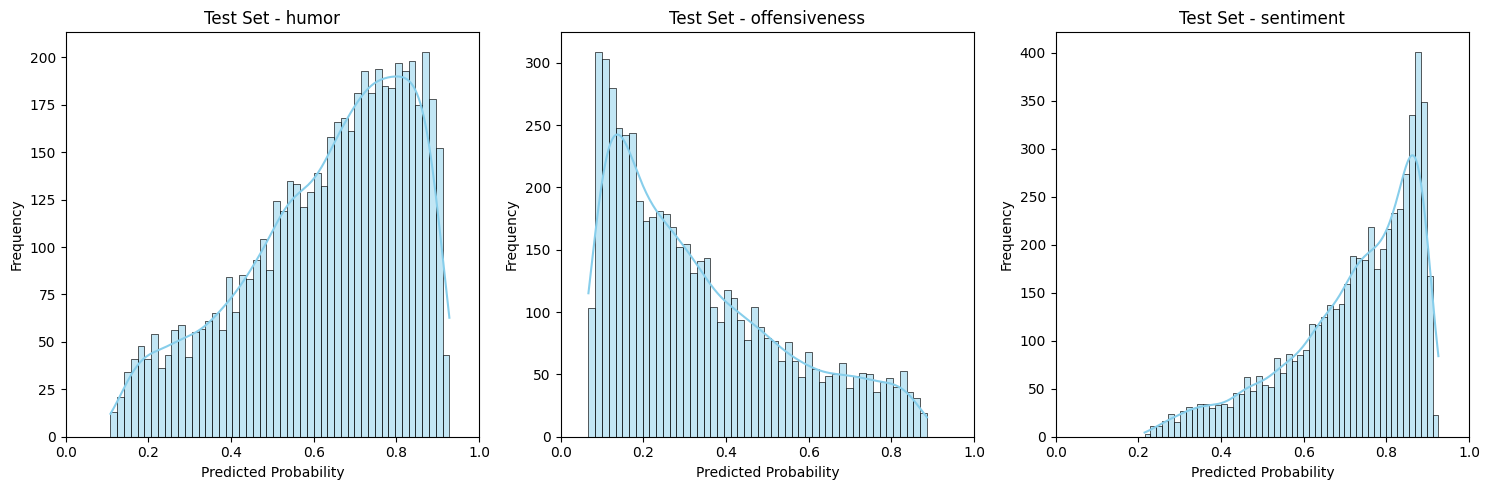

In [6]:
# Replace with your actual file path
data_path = "../data/labeled_jokes_classification_mistral:latest.parquet"
results = main(data_path, nrows=None)

In [7]:
# Example of using the model with a new joke
print("\nExample prediction:")
sample_joke = "Why don't scientists trust atoms? Because they make up everything!"
predicted_ratings = predict_joke_ratings(sample_joke)
for dimension, rating in predicted_ratings.items():
    print(f"{dimension}: {rating}")


Example prediction:
humor: 1
offensiveness: 0
sentiment: 1


In [8]:
# Example of using the model with a new joke
print("\nExample prediction:")
sample_joke = "Mother"
predictions = predict_joke_ratings(sample_joke)
for dimension, score in predictions.items():
    print(f"{dimension}: {score:.2f}")


Example prediction:
humor: 0.00
offensiveness: 0.00
sentiment: 1.00


In [1]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, classification_report

# Synthetic example with 5 samples and 3 labels
# Rows = samples, Columns = labels (e.g., humor, offensiveness, sentiment)
y_true = np.array([
    [1, 0, 1],
    [0, 1, 0],
    [1, 1, 0],
    [0, 0, 0],
    [1, 0, 0]
])

# Predicted labels for the same samples
y_pred = np.array([
    [1, 0, 0],
    [0, 1, 1],
    [1, 0, 0],
    [0, 0, 0],
    [0, 0, 0]
])

# Compute confusion matrices per label
cms = multilabel_confusion_matrix(y_true, y_pred)

print("Confusion matrices per label (TN, FP, FN, TP):")
for i, cm in enumerate(cms):
    tn, fp, fn, tp = cm.ravel()
    print(f" Label {i}: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

# Compute and display precision, recall, F1 per label plus macro/micro averages
print("\nClassification report:")
print(classification_report(y_true, y_pred, zero_division=0))


Confusion matrices per label (TN, FP, FN, TP):
 Label 0: TN=2, FP=0, FN=1, TP=2
 Label 1: TN=3, FP=0, FN=1, TP=1
 Label 2: TN=3, FP=1, FN=1, TP=0

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      0.50      0.67         2
           2       0.00      0.00      0.00         1

   micro avg       0.75      0.50      0.60         6
   macro avg       0.67      0.39      0.49         6
weighted avg       0.83      0.50      0.62         6
 samples avg       0.50      0.40      0.40         6

